最初に必要なライブラリを読み込みます。

In [1]:
from sympy import *
from sympy.physics.quantum import *
from sympy.physics.quantum.qubit import Qubit, QubitBra, measure_all, measure_all_oneshot,measure_partial, matrix_to_qubit
from sympy.physics.quantum.gate import H,X,Y,Z,S,T,CPHASE,CNOT,SWAP,UGate,CGateS,gate_simp,OneQubitGate
from sympy.physics.quantum.gate import IdentityGate as _I
from sympy.physics.quantum.qft import *
from sympy.physics.quantum.matrixcache import matrix_cache
matrix_cache.cache_matrix('Tdg',Matrix([[1, 0], [0, exp(-I*pi/4)]]))
matrix_cache.cache_matrix('Sdg',Matrix([[1, 0], [0, -I]]))
matrix_cache.cache_matrix('V',(1/2)*Matrix([[1+I, 1-I], [1-I, 1+I]]))
matrix_cache.cache_matrix('Vdg',(1/2)*Matrix([[1-I, 1+I], [1+I, 1-I]]))

CZ = CPHASE

class Tdg(OneQubitGate): # T^{\dagger} 演算
    gate_name = u'Tdg'
    gate_name_latex = u'T^{\dagger}'
    def get_target_matrix(self, format='sympy'):
        return matrix_cache.get_matrix('Tdg', format)

class Sdg(OneQubitGate): # S^{\dagger} 演算
    gate_name = u'Sdg'
    gate_name_latex = u'S^{\dagger}'
    def get_target_matrix(self, format='sympy'):
        return matrix_cache.get_matrix('Sdg', format)

class V(OneQubitGate): # √X 演算
    gate_name = u'V'
    gate_name_latex = u'V'
    def get_target_matrix(self, format='sympy'):
        return matrix_cache.get_matrix('V', format)

class Vdg(OneQubitGate): # √X ^{\dagger}演算
    gate_name = u'Vdg'
    gate_name_latex = u'V^{\dagger}'
    def get_target_matrix(self, format='sympy'):
        return matrix_cache.get_matrix('Vdg', format)

def CV(c,t):  return CGateS((c),V(t))
def CVdg(c,t):  return CGateS((c),Vdg(t))

def CCX(c1,c2,t):  return CGateS((c1,c2),X(t))
def Toffoli(c1,c2,t):  return CGateS((c1,c2),X(t))
def CCZ(c1,c2,t): return (H(t)*CCX(c1,c2,t)*H(t)) # CCZ演算子を定義します。
def hadamard(s,n):
    h = H(s)
    for i in range(s+1,n+s): h = H(i)*h
    return h

def disp1Q(u): print(u); display(represent(u,nqubits=1)); CircuitPlot(u,nqubits=1)
def disp2Q(u): print(u); display(represent(u,nqubits=2)); CircuitPlot(u,nqubits=2)

from sympy.printing.dot import dotprint
init_printing()

%matplotlib inline
import matplotlib.pyplot as plt
from sympy.physics.quantum.circuitplot import CircuitPlot,labeller, Mz,CreateOneQubitGate
alpha, beta, gamma, delta = Symbol(r'\alpha'), Symbol(r'\beta'), Symbol(r'\gamma'), Symbol(r'\delta'), 
psi, phi, theta, chi = Symbol(r'\psi'), Symbol(r'\phi'), Symbol(r'\theta'), Symbol(r'\chi') 
from qutip import *
import numpy as np

（副読本）
* ニールセン・チャン「量子コンピュータと量子通信」（ここでは N,C"QCQI" と書きます）
* arXivに公開されている論文

# 第3章 量子計算の基本パッケージ
## 3.1 量子計算の基本戦略

In [2]:
state0 = Qubit('000')
state1=qapply(X(0)*X(1)*X(2)*state0)
state1

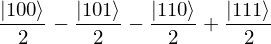

In [3]:
state2=qapply(H(0)*H(1)*state1)
state2

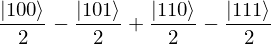

In [4]:
state3=qapply(Toffoli(2,1,0)*state2)
state3

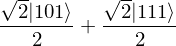

In [5]:
state4=qapply(H(0)*state3)
state4

* ベルンシュタイン・ヴァジラニのアルゴリズム

$ \displaystyle f_s(x) = \sum_{i=0}^{n} s_i x_i \mod 2$

n個のパラメータ$s_i$を推定する

例えば、

|s＼x| 0 | 1 | 0 | 0 |
|:--:|:--:|:--:|:--:|:--:|
|0|0|||
|1||1||
|1|||0|
|0||||0|


この場合は、$ f_s(0100=3)=1 $ となりますが、n回試行すれば、s＝０１１０　を推定できる。（古典の場合） 

量子アルゴリズムでは、１回で推定できる。

n=4で試してみる

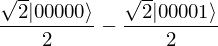

In [6]:
# i)
n=4
state0 = qapply(H(0)*X(0)*Qubit('0'*(n+1)))
state0

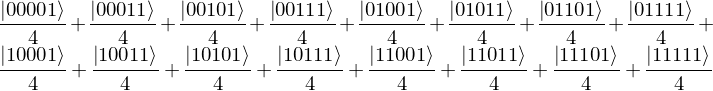

In [7]:
# ii)
state1 = qapply(hadamard(0,n+1)*state0)
state1

（途中までですが、続きはテキストで確認）

## 3.2 アダマールテスト

アダマール テストの前に・・・　位相推定の原形をご紹介

![位相推定の原形](image1.png)

* 位相キックバック

※課題として、Control-U の回路をどう作るか？

![Quantum Phase Estimation](image2.png)


![Hadamard test](image3.png)


![Hadamard Test 2](image4.png)

## 3.3 内積の計算（スワップテスト）

![SWAP Test](image5.png)

$\begin{equation}
\left.\begin{aligned}
\lvert \psi \rangle \lvert \phi \rangle
&= ( a_0 \lvert 0 \rangle + a_1 \lvert 1 \rangle )
\otimes ( b_0 \lvert 0 \rangle + b_1 \lvert 1 \rangle ) \\
&\xrightarrow{CNOT}
a_0 \lvert 0 \rangle \otimes( b_0 \lvert 0 \rangle + b_1 \lvert 1 \rangle ) + a_1 \lvert 1 \rangle
\otimes ( b_0 \lvert 1 \rangle + b_1 \lvert 0\rangle ) \\
&\xrightarrow{H}
\frac{1}{\sqrt{2}} \{ a_0 (\lvert 0 \rangle + \lvert 1 \rangle)\otimes( b_0 \lvert 0 \rangle + b_1 \lvert 1 \rangle ) + a_1 (\lvert 0 \rangle - \lvert 1 \rangle)
\otimes ( b_0 \lvert 1 \rangle + b_1 \lvert 0\rangle ) \} \\
 \end{aligned} \right.
\end{equation}$

## 3.4 位相を上手に使う
### 3.4.1 離散フーリエ変換（量子フーリエ変換）

### 3.4.2 行列の固有値推定（量子位相推定）

![位相差を調べる](image6.png)

![Quantum Phase Estimation](image2.png)

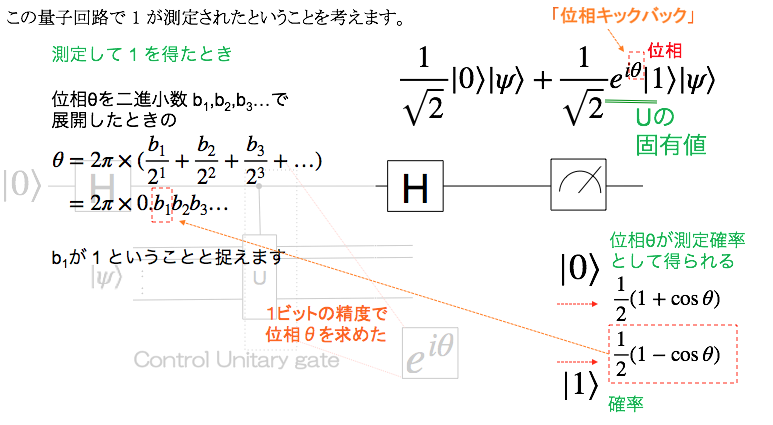

![Quantum Phase Estimation 精度](image7.png)

![Kitaevの位相推定](image8.png)

![任意の量子状態を入力](image9.png)

![量子フーリエ変換（QFT）](image10.png)

## 3.5 振幅を上手に使う

**keywords**
    
    
* 振幅増幅（Amplitude Amplification）
* 振幅推定（Amplitude Estimation）


p.70 では　$ \lvert \alpha \rangle $ と $ \lvert \beta \rangle $ が直行基底としてロジックが書かれています。 

Groverのアルゴリズムで見てみましょう

![Grover 1](grover1.png)

![Grover 2](grover2.png)

![Grover 3](grover3.png)

![grover 4(2-2)](grover4.png)

![grover 5(2-3)](grover5.png)

![Grover 6](grover6.png)

![Grover 7](grover7.png)